# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython
import geopandas
import contextily as cx
from math import asin, cos, radians, sin, sqrt


from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform

rng = np.random.default_rng()

import seaborn as sns

from scipy import sparse
from matplotlib.dates import DateFormatter

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

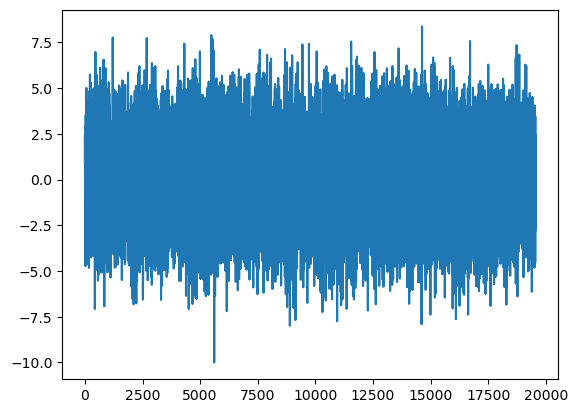

In [3]:
plt.plot(X_train[0])

In [4]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


# Question 2

In [5]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 3

In [2]:
M=9
def gU(lambda_, a, R):
    return np.where((-R*a <= lambda_ ) & (lambda_< 0), 1/2*(1+np.cos(2*np.pi*(lambda_/(a*R) + 1/2))), 0)

def gm_hat(lambda_, m, lambda_max, R):
    a = lambda_max/(M+1-R)
    return gU(lambda_ - a*m, a, R)

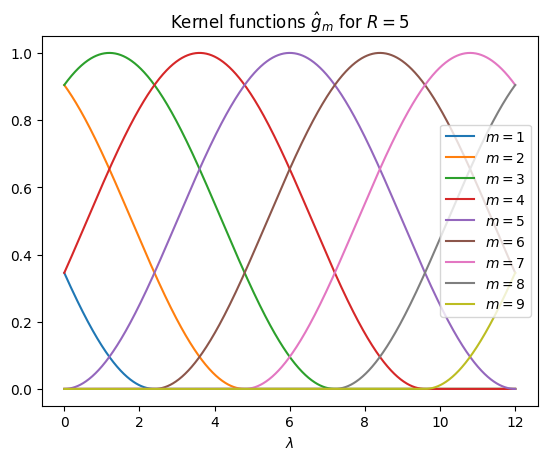

In [3]:
lambda_max = 12
R = 5

lambda_values = np.linspace(0, lambda_max, 1000)
for m in np.arange(1, M+1):
    plt.plot(lambda_values, gm_hat(lambda_values, m, lambda_max, R), label=fr'$m={m}$')

plt.title(fr'Kernel functions $\hat{{g}}_m$ for $R={R}$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

# Question 4

## Utility functions: 

In [4]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    return graph.is_connected()

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [5]:
# Loading the dataset
data_df, stations_df, description = load_molene_meteo_dataset()

In [6]:
# Creating a dataframe with the temperatures
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [10]:
missing_values_series = temperature_df.isna().sum(axis=0) # Counting the NaN in each column

print(f'There are {len(missing_values_series[missing_values_series>0])} stations with at least 1 missing values in the temperature.')
print('The stations with missing values are:')
for station in missing_values_series[missing_values_series>0].index:
    print(station)

There are 18 stations with at least 1 missing values in the temperature.
The stations with missing values are:
ARZAL
BATZ
BEG_MEIL
BREST-GUIPAVAS
BRIGNOGAN
CAMARET
LANDIVISIAU
LANNAERO
LANVEOC
OUESSANT-STIFF
PLOUAY-SA
PLOUDALMEZEAU
PLOUGONVELIN
QUIMPER
RIEC SUR BELON
SIZUN
ST NAZAIRE-MONTOIR
VANNES-MEUCON


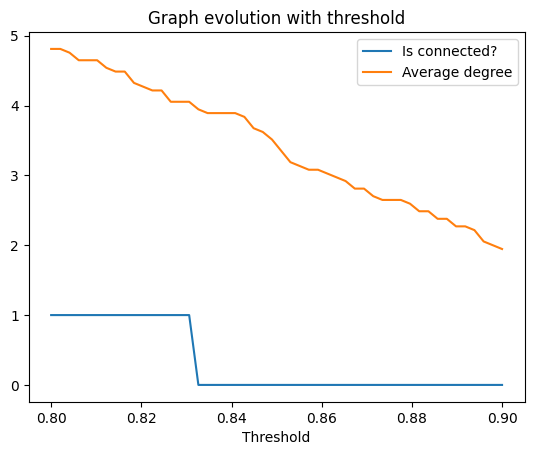

In [11]:
temperature_df_cleaned = temperature_df.dropna(axis=1)  # We remove stations with missing values (There are 37 columns left)
stations_df_cleaned = stations_df.set_index('Nom').loc[temperature_df_cleaned.columns].reset_index() # In the stations dataframe, we also only keep the stations left

# Computation of the distance matrix using the code of the TP3
stations_np = stations_df_cleaned[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)

# Construction of the graph with exponential smoothing using the code of the TP3
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold_values = np.linspace(0.8, 0.9) # Range of threshold to be tested
connected = [] # List of boolean indicating if the graph is connected
avg_degree = [] # List of average degree in the graph

# Testing the range of threshold values
for threshold in threshold_values: 
    adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
    G = graphs.Graph(adjacency_matrix) 
    connected.append(is_connected(G))
    avg_degree.append(2*G.Ne/G.N) # The average degree is 2*(#edges)/(#vertices) because each edge links two vertices


# Graphical representation of the evolution 
plt.plot(threshold_values, np.array(connected, dtype=float), label='Is connected?')
plt.plot(threshold_values, avg_degree, label='Average degree')
plt.title('Graph evolution with threshold')
plt.xlabel('Threshold')
plt.legend()
plt.show()

We observe that the threshold is around $0.83$ when the graph becomes connected. For this value, the average degree in the graph is approximately $4$ which is greather than $3$.  

In [12]:
# We verify that 0.83 works 
threshold = 0.83
adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G = graphs.Graph(adjacency_matrix)

print(
    f"The graph is {'not ' if not is_connected(G) else ''}connected, with {G.N} nodes, {G.Ne} edges. Its average degree is {2*G.Ne/G.N}."
)

The graph is connected, with 37 nodes, 75 edges. Its average degree is 4.054054054054054.


In [13]:
# Computing smoothness in the graph over time
smoothness_values_over_time = [] 
for date in temperature_df_cleaned.index:
    x = temperature_df_cleaned.loc[date].to_numpy() # Graph signal
    L = G.L.todense() # Laplacian matrix of the graph
    smoothness_value = float(x.T @ L @ x) # Classical computation of the smoothness value
    smoothness_values_over_time.append(smoothness_value)

# Minimum of the smoothness = signal is the smoothest
smoothness_argmin = np.argmin(smoothness_values_over_time)
smoothest_date = temperature_df_cleaned.index[smoothness_argmin]
print('The signal is the smoothest at', smoothest_date)

# Maximum of the smoothness = signal is the least smooth
smoothness_argmax = np.argmax(smoothness_values_over_time)
least_smooth_date = temperature_df_cleaned.index[smoothness_argmax]
print('The signal is the least smooth at', least_smooth_date)

C:\Users\victo\AppData\Local\Temp\ipykernel_21096\2156375483.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothness_value = float(x.T @ L @ x) # Classical computation of the smoothness value


The signal is the smoothest at 2014-01-24 23:00:00
The signal is the least smooth at 2014-01-21 03:00:00


# Question 5

In [14]:
R = 3
eigenvals, eigenvects = eigh(G.L.todense()) # Eigendecomposition of the Laplacian matrix

def GWT(f, m, v):
    """Graph Wavelet Transform of the signal f applied to m, v"""
    f_hat = eigenvects.T @ f # Fourier transform of f
    return np.sum(gm_hat(eigenvals, m, eigenvals[-1], R)*f_hat*eigenvects[v, :]) 

def features_vector(f, v):
    """Compute the vector of features using GWT for node v"""
    return np.array([GWT(f, m, v) for m in range(1, M+1)]) 

def energy_profile(f):
    """Compute the energy profile for each node of the graph"""
    profile = np.zeros((G.N, 3)) # Each row is a node, each line is low/medium/high frequency energy
    for v in range(G.N):
        features = features_vector(f, v)
        profile[v] = np.sum(np.reshape(features, (3,3))**2, axis=1)
    return profile

In [15]:
# Temperatures profiles of the two extremes
smoothest_temperature = temperature_df_cleaned.loc[smoothest_date].to_numpy()
least_smooth_temperature = temperature_df_cleaned.loc[least_smooth_date].to_numpy()
initial_temperature = temperature_df_cleaned.loc['2014-01-01 00:00:00'].to_numpy()

# Computing the repartition of the energy between the low/medium/high frequencies
smoothest_energy_profile = energy_profile(smoothest_temperature)
least_smooth_energy_profile = energy_profile(least_smooth_temperature)
initial_energy_profile = energy_profile(initial_temperature)

# Classifying into the 3 classes
smoothest_classif = np.argmax(smoothest_energy_profile, axis=1)
least_smooth_classif = np.argmax(least_smooth_energy_profile, axis=1)
initial_classif = np.argmax(initial_energy_profile, axis=1)

In [16]:
# For visualization
CRS = "EPSG:4326"

stations_gdf = geopandas.GeoDataFrame(
    stations_df_cleaned,
    geometry=geopandas.points_from_xy(stations_df_cleaned.Longitude, stations_df_cleaned.Latitude),
).set_crs(CRS)

# Colors for the different frequencies
colors = ['blue', 'green', 'red']
labels = ['Low Frequency', 'Medium Frequency', 'High Frequency']

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygsp\plotting.py:610: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(


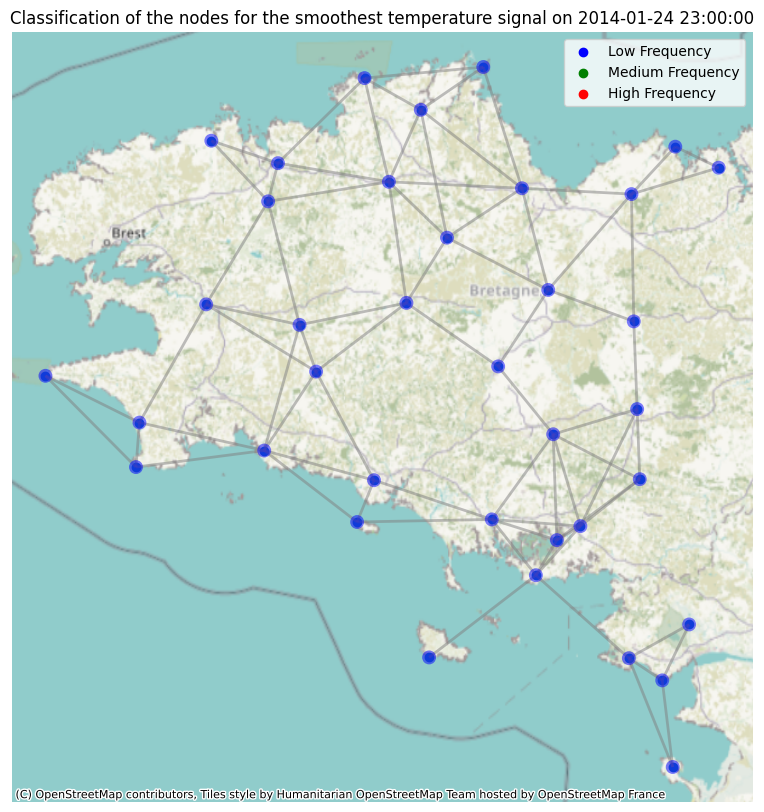

In [17]:
# Visualization of the smoothest profile
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

# Set coordinates for graph nodes
G.set_coordinates(stations_np)

# Plot graph with node colors
node_colors = [colors[c] for c in smoothest_classif]
G.plot(ax=ax, vertex_color=node_colors, vertex_size=100)

ax.set_title(f"Classification of the nodes for the smoothest temperature signal on {smoothest_date}")

for i in range(len(colors)):
    ax.scatter([], [], c=colors[i], label=labels[i])
ax.legend(loc='upper right')

plt.show()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygsp\plotting.py:610: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(


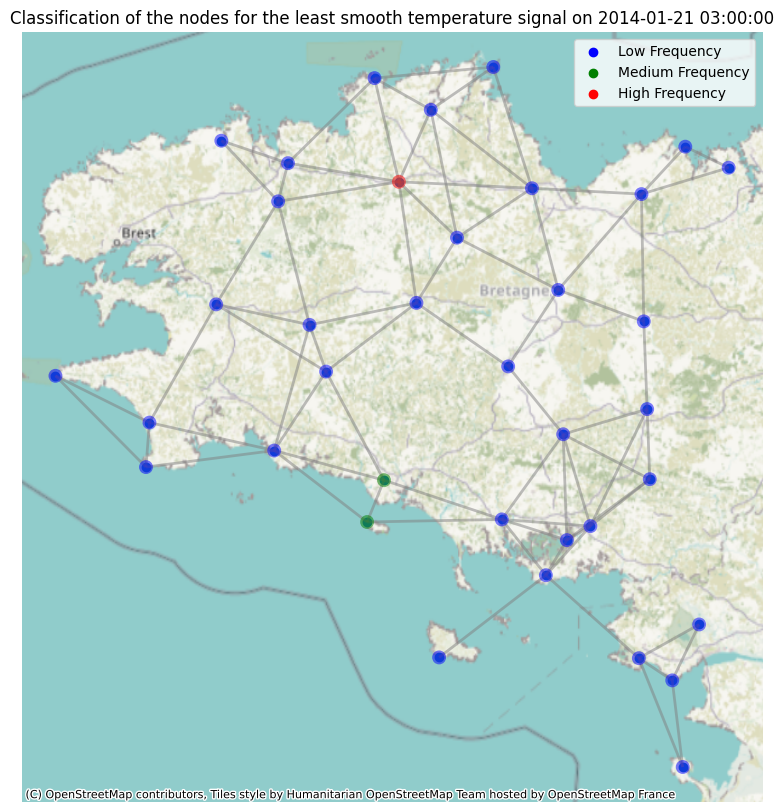

In [18]:
# Visualization of the least smooth profile
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

# Set coordinates for graph nodes
G.set_coordinates(stations_np)

# Plot graph with node colors
node_colors = [colors[c] for c in least_smooth_classif]
G.plot(ax=ax, vertex_color=node_colors, vertex_size=100)

ax.set_title(f"Classification of the nodes for the least smooth temperature signal on {least_smooth_date}")

for i in range(len(colors)):
    ax.scatter([], [], c=colors[i], label=labels[i])
ax.legend(loc='upper right')

plt.show()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygsp\plotting.py:610: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(


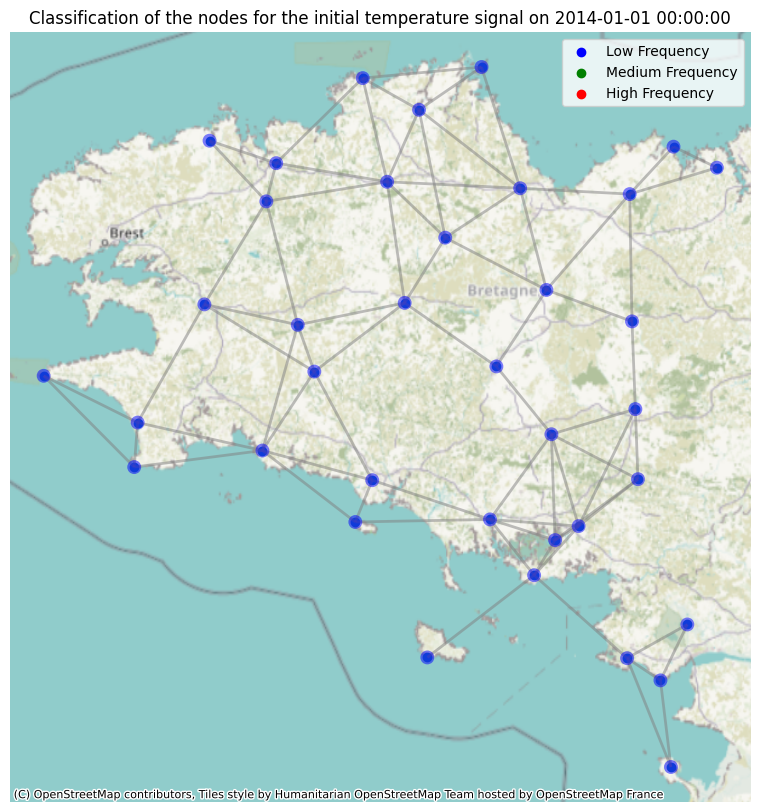

In [19]:
# Visualization of the initial profile
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

# Set coordinates for graph nodes
G.set_coordinates(stations_np)

# Plot graph with node colors
node_colors = [colors[c] for c in initial_classif]
G.plot(ax=ax, vertex_color=node_colors, vertex_size=100)

ax.set_title(f"Classification of the nodes for the initial temperature signal on {temperature_df_cleaned.index[0]}")

for i in range(len(colors)):
    ax.scatter([], [], c=colors[i], label=labels[i])
ax.legend(loc='upper right')

plt.show()

# Question 6

In [23]:
average_temperatures = np.mean(temperature_df_cleaned, axis=1) # Average temperature at each timestamp

majority_classes = [] # Array with the majority class at each timestamp
for temperature_profile in temperature_df_cleaned.to_numpy():
    energies = energy_profile(temperature_profile) # Compute the energy profile of the graph signal 
    classifications = np.argmax(energies, axis=1) # Each Node are classified
    majority_classes.append(np.bincount(classifications).argmax()) # We count the number node in each class and classify the timestamp

marker_colors = [colors[c] for c in majority_classes] # Colors for the plot

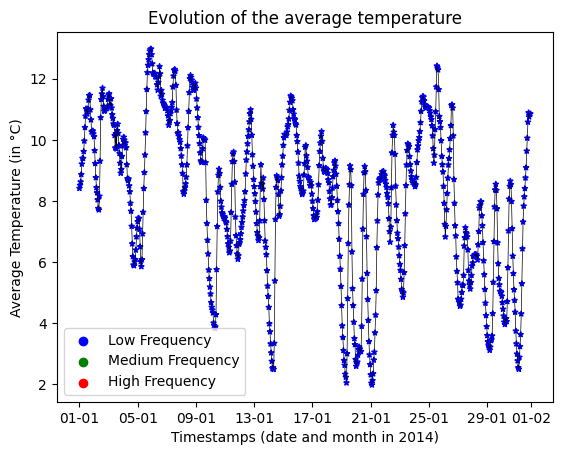

In [27]:
plt.scatter(temperature_df_cleaned.index, average_temperatures, c=marker_colors, marker='*', s=15)
plt.plot(temperature_df_cleaned.index, average_temperatures, 'k', linewidth=.5)
date_form = DateFormatter("%d-%m")
plt.gca().xaxis.set_major_formatter(date_form)

for i in range(len(colors)):
    plt.scatter([], [], c=colors[i], label=labels[i])
plt.legend()

plt.title('Evolution of the average temperature')
plt.xlabel('Timestamps (date and month in 2014)')
plt.ylabel('Average Temperature (in °C)')
plt.show()

# Question 7

In [29]:
# Construction of G', the temporal graph
T = len(temperature_df_cleaned) # Number of timestamps
G_prime = graphs.Path(T) # the temporal graph is a simple line

# Construction of H via its adjacency matrix
W_H = sparse.kron(G.W, sparse.eye(T)) + sparse.kron(sparse.eye(G.N), G_prime.W) # Use of the formula with Kronecker products
H = graphs.Graph(W_H)

print(f'H is the total graph. It has {H.N} vertices and {H.Ne} edges')

H is the total graph. It has 27528 vertices and 83291 edges


In [ ]:
eigenvals_prime, eigenvects_prime = eigh(G_prime.L.todense()) # Eigendecomposition of the Laplacian matrix of G'


[[ 0.03666178  0.05184747 -0.05184712 ... -0.00032839 -0.00021893
   0.00010946]
 [ 0.03666178  0.05184654 -0.05184342 ...  0.00098513  0.00065677
  -0.00032839]
 [ 0.03666178  0.0518447  -0.05183603 ... -0.0016417  -0.00109457
   0.00054732]
 ...
 [ 0.03666178 -0.0518447  -0.05183603 ...  0.0016417  -0.00109457
  -0.00054732]
 [ 0.03666178 -0.05184654 -0.05184342 ... -0.00098513  0.00065677
   0.00032839]
 [ 0.03666178 -0.05184747 -0.05184712 ...  0.00032839 -0.00021893
  -0.00010946]]


In [77]:
def GWT_H(f, m, v):
    """Graph Wavelet Transform of the signal f applied to m, v"""
    # f_hat = eigenvects.T @ f # Fourier transform of f
    F_hat = eigenvects.T @ f.T @ eigenvects_prime
    Lambda = eigenvals[:, None] + eigenvals_prime[None, :]
    p = v % G.N
    q = v // G.N
    return np.sum(gm_hat(Lambda, m, Lambda.max(), R)*F_hat*(eigenvects[p, :, None]*eigenvects_prime[q, None, :]) )

def features_vector_H(f, v):
    """Compute the vector of features using GWT for node v"""
    return np.array([GWT_H(f, m, v) for m in range(1, M+1)]) 


def energy_profile_H(f):
    profile = np.zeros((H.N, 3)) # Each row is a node, each line is low/medium/high frequency energy
    for v in range(H.N):
        features = features_vector_H(f, v)
        profile[v] = np.sum(np.reshape(features, (3,3))**2, axis=1)
    return profile

In [80]:
energies = energy_profile_H(temperature_df_cleaned.to_numpy())

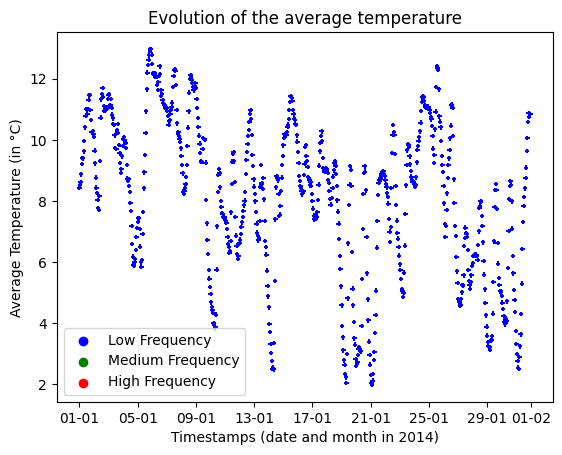

In [87]:
classifications = np.argmax(energies, axis=1)
classifications = classifications.reshape((T, G.N))

majority_classes = []
for t in range(T):
    majority_classes.append(np.bincount(classifications[t]).argmax())


marker_colors = [colors[c] for c in majority_classes]

plt.scatter(temperature_df_cleaned.index, average_temperatures, c=marker_colors, marker='+', s=10)
date_form = DateFormatter("%d-%m")
plt.gca().xaxis.set_major_formatter(date_form)

for i in range(len(colors)):
    plt.scatter([], [], c=colors[i], label=labels[i])
plt.legend()

plt.title('Evolution of the average temperature')
plt.xlabel('Timestamps (date and month in 2014)')
plt.ylabel('Average Temperature (in °C)')
plt.show()